In [2]:
###Importing
from imdbpie import Imdb
import pandas as pd
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

In [4]:
###Retreiving Top 250 IMDB Data
def get_top_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

In [5]:
entries = get_top_250()

In [6]:
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

In [7]:
entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [8]:
df = pd.DataFrame(entries_dict_list)

In [ ]:
###Function for Total Gross
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/'+entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [ ]:
###Takes awhile to run. Pulling from stored variable instead.


#grosses = [(e, get_gross(e)) for e in entries]

In [13]:
###Pulling in stored data from another notebook. Takes forever to run the code.
%store -r budget

In [11]:
%store -r grosses

In [14]:
###Adding Gross and Budget to Dataframe

In [16]:
df = pd.DataFrame(entries_dict_list)

In [18]:
df1 = pd.DataFrame(grosses,columns=['imdbID', 'Gross'])

In [19]:
df = pd.merge(df, df1)

In [21]:
df2 = pd.DataFrame(budget,columns=['imdbID', 'Budget'])

In [22]:
df = pd.merge(df, df2)

In [28]:
###Make Rating a Float
df.imdbRating = df.imdbRating.astype(float)

In [33]:
###Fix Votes
def intvotes(x):
    y = x.replace(',', '').strip()
    return int(y)
df.imdbVotes = df.imdbVotes.apply(intvotes)

In [29]:
###Count Vectorization for Plot, Genre, Actors, Director, Awards

In [30]:
###GENRES
cv1 = CountVectorizer(max_features=10)
data1 = cv1.fit_transform(df.Genre).todense()
columns1 = ['genre_'+c for c in cv1.get_feature_names()]
genredf = pd.DataFrame(data1, columns=columns1)

In [31]:
df = pd.concat([df, genredf], axis = 1)

In [35]:
###PLOT
cv10 = CountVectorizer(max_features=10, stop_words='english', ngram_range=(2,3))
data10 = cv10.fit_transform(df.Plot).todense()
columns10 = ['plot_'+c for c in cv10.get_feature_names()]
plotdf = pd.DataFrame(data10, columns=columns10)

In [37]:
df = pd.concat([df, plotdf], axis = 1)

In [40]:
###ACTORS
cv2 = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+', max_features=10)
data2 = cv2.fit_transform(df.Actors).todense()
columns2 = ['actor: '+c for c in cv2.get_feature_names()]
actorsdf = pd.DataFrame(data2, columns=columns2)

In [41]:
df = pd.concat([df, actorsdf], axis = 1)

In [42]:
###DIRECTORS
cv3 = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+', max_features=10)
data3 = cv3.fit_transform(df.Director).todense()
columns3 = ['director: '+c for c in cv3.get_feature_names()]
directorsdf = pd.DataFrame(data3, columns=columns3)

In [43]:
df = pd.concat([df, actorsdf], axis = 1)

In [44]:
###OSCARS WON
cv4 = CountVectorizer(token_pattern=u'(?<=[Ww]on)(.*)(?=[Oo]scar)', max_features=10)
data4 = cv4.fit_transform(df.Awards).todense()
columns4 = ['oscars: '+c for c in cv4.get_feature_names()]
oscarsdf = pd.DataFrame(data4, columns=columns4)

In [45]:
df = pd.concat([df, oscarsdf], axis = 1)

In [225]:
X = df

In [226]:
X = X.replace('N/A', np.nan)

In [227]:
X.dropna(inplace=True)

In [228]:
X = X.iloc[:, 18:]

In [229]:
y = X['imdbRating']

In [230]:
del X['imdbRating']

In [232]:
###Scale the non-binary columns
X['Gross'] = MinMaxScaler().fit_transform(X['Gross'].astype(float).reshape(-1, 1))
X['imdbVotes'] = MinMaxScaler().fit_transform(X['imdbVotes'].astype(float).reshape(-1, 1))
X['Budget'] = MinMaxScaler().fit_transform(X['Budget'].astype(float).reshape(-1, 1))

In [241]:
def do_cross_val(model):
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='r2')
    return scores.mean(), scores.std()

In [242]:
dtr = DecisionTreeRegressor()
do_cross_val(dtr)

(-0.004797215144291123, 0.34670517838680143)

In [243]:
gb = GradientBoostingRegressor()
do_cross_val(gb)

(0.40745530772858096, 0.15570310846188254)

In [244]:
rf = RandomForestRegressor()
do_cross_val(rf)

(0.46272526556480897, 0.10438108231872574)

In [216]:
#RandomForest gives the best combo of R2 mean/std.

In [245]:
rf.fit(X,y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

In [246]:
feature_importances.head(10)

,importance
imdbVotes,0.624943
Gross,0.098218
Budget,0.088358
genre_thriller,0.020693
actor: clint eastwood,0.015084
plot_vietnam war,0.010917
oscars: 3,0.010801
plot_new york,0.009904
actor: robert de,0.009378
oscars: 1,0.009290


We see that imdbVotes is by far the most important variable in predicting imdbRating. The budget and the gross were also important factors. The genre, actors, directors, and plot were all basically meaningless.

In [250]:
###Checking importance if we remove votes
#Xnovotes

In [251]:
rfno = RandomForestRegressor()
do_cross_val(rfno)

(0.41741810973991972, 0.11844001191169515)

In [252]:
rfno.fit(Xnovotes,y)
importancesno = rfno.feature_importances_
indicesno = np.argsort(importancesno)[::-1]
feature_importancesno = pd.DataFrame(rfno.feature_importances_, index = Xnovotes.columns, columns=['importance']).sort_values('importance', ascending=False)

In [253]:
feature_importancesno.head(10)

,importance
Gross,0.198586
Budget,0.184683
actor: morgan freeman,0.057334
genre_action,0.042268
oscars: 1,0.041773
genre_crime,0.039478
oscars: 6,0.030968
oscars: 7,0.029304
actor: clint eastwood,0.027739
actor: brad pitt,0.027207


Now gross and budget have more of an impact and the other variables still have minimal impact.

In [177]:
Xvotes = X['imdbVotes']

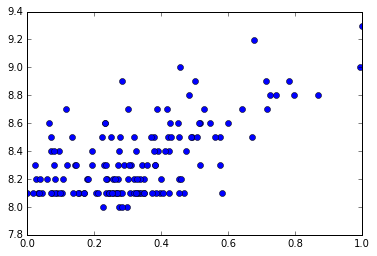

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

line = plt.figure()
plt.plot(Xvotes, y, "o")
####Visual relationship between Votes and Rating.

In [179]:
Xbudget = X['Budget']

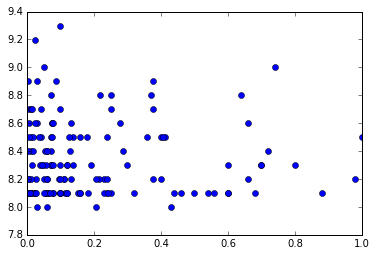

In [192]:
line = plt.figure()
plt.plot(Xbudget, y, "o")
###Relationship between Budget and Rating

In [181]:
Xgross = X['Gross']

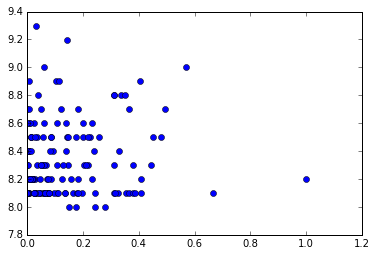

In [193]:
line = plt.figure()
plt.plot(Xgross, y, "o")
###Relationship between Gross and Rating

In [125]:
cv = KFold(10, shuffle=True)

dt = DecisionTreeRegressor()

s = cross_val_score(dt, X, y, cv=cv)
print "{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3))

Decision Tree Score:	-0.849 ± 2.14


In [126]:
rf = RandomForestRegressor()

srf = cross_val_score(rf, X, y, cv=cv)
print "{} Score:\t{:0.3} ± {:0.3}".format("RandomForest", srf.mean().round(3), srf.std().round(3))

RandomForest Score:	-0.265 ± 0.549


In [129]:
ab = AdaBoostRegressor()

sab = cross_val_score(ab, X, y, cv=cv)
print "{} Score:\t{:0.3} ± {:0.3}".format("AdaBoost", sab.mean().round(3), sab.std().round(3))

AdaBoost Score:	-0.888 ± 0.812
